# Contents

[**1. Get the relevant data from SQL DB**](#get_data)

[**2. Clean and preprocess the data**](#clean_data)

[**3. Get word distributions in the training set**](#bow)

[**4. Apply modified WMD to validation sets**](#wmd)

[**5. Accuracy on the test set**](#test)

[**6. Implementing a threshold**](#thresh)

---

In [2]:
import nltk
import numpy as np
import os
import pandas as pd
import psycopg2
import re
import spacy
import sys
import time
 
from slackclient import SlackClient
from __future__ import division

from pyemd import emd
from sklearn.metrics import euclidean_distances
from sklearn.metrics import accuracy_score

from nltk.corpus import stopwords
from nltk.tokenize import WordPunctTokenizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn; seaborn.set() # For pretty plots
%config InlineBackend.figure_format='retina'

---

# <a name="get_data">1. Get the relevant data from SQL DB</a>

Connect to my local SQL DB and pull the comments from all the subreddits we have:

In [3]:
con = psycopg2.connect(database = 'slack_police', user = 'aficnar')

In [4]:
all_subreddits = pd.read_sql("SELECT id FROM main_subreddits", con)['id'].tolist()
all_subreddit_names = pd.read_sql("SELECT name FROM main_subreddits", con)['name'].tolist()
print all_subreddit_names
print all_subreddits

['diving', 'Handball', 'corgi', 'datascience', 'MachineLearning']
['2qr9w', '2rr72', '2rdw8', '2sptq', '2r3gv']


In [16]:
data = []
for subreddit_id in all_subreddits:
    sql_query = "SELECT content FROM main_comments WHERE subreddit_id = '%s'" % subreddit_id
    data_local = pd.read_sql(sql_query, con)['content'].tolist()
    data.append(data_local)

In [17]:
[len(datum) for datum in data]

[5111, 5885, 5006, 5008, 5013]

Take only the first 5000 from each channel:

In [19]:
total_size = 5000
data = [datum[:total_size] for datum in data]
lengths = [len(datum) for datum in data]
lengths

[5000, 5000, 5000, 5000, 5000]

---

# <a name="clean_data">2. Clean and pre-process the data</a>

Get rid of the Emojis

In [8]:
emoji_pattern = re.compile(
    u"(\ud83d[\ude00-\ude4f])|"  # emoticons
    u"(\ud83c[\udf00-\uffff])|"  # symbols & pictographs (1 of 2)
    u"(\ud83d[\u0000-\uddff])|"  # symbols & pictographs (2 of 2)
    u"(\ud83d[\ude80-\udeff])|"  # transport & map symbols
    u"(\ud83c[\udde0-\uddff])"   # flags (iOS)
    "+", flags = re.UNICODE)

Load stopping words:

In [9]:
stopset = set(stopwords.words('english'))
my_stopset = set(['would', 'http', 'also', 'com', 'https']).union(stopset)

Function that takes a post, cleans it and returns list of tokens:

In [11]:
def clean_post(post):
    if type(post) == str: conv_post = unicode(post, "utf-8")
    else: conv_post = post
    u_post = emoji_pattern.sub('', conv_post)
    u_post_let = re.sub("[^a-zA-Z]", " ", u_post) # Only words
    tokens = WordPunctTokenizer().tokenize(u_post_let)
    clean = [token.lower() for token in tokens if token.lower() not in my_stopset and len(token) > 2]
    return clean

Tokenize our datasets:

In [12]:
data_tokenized = [[clean_post(comment) for comment in datum] for datum in data]
print data_tokenized[0][0]

[u'dan', u'widely', u'recognised', u'qld', u'seen', u'dive', u'assured', u'anywhere', u'mean', u'available', u'seen']


Initialize Spacy's language pipeline

In [20]:
vectorizer = CountVectorizer(stop_words = None)
nlp = spacy.load('en')

Function to check if a word is in vocabulary AND is either a noun, a verb or an adjective:

In [21]:
pos_set = set([u'NOUN', u'ADJ', u'VERB'])
def oov_checker_plus(s):
    if type(s) == str: s = unicode(s, "utf-8")
    is_oov = nlp(s)[0].is_oov
    is_info_word = nlp(s)[0].pos_ in pos_set
    return (not is_oov) and is_info_word

Only include the tokens that satisfy this, and rejoin them into messages:

In [22]:
data_tokenized = [[[t for t in tokens if oov_checker_plus(t) == True] 
                    for tokens in datum] for datum in data_tokenized]

In [23]:
data_clean = [[" ".join(tokens) for tokens in datum] for datum in data_tokenized]

Note that there are quite a few messages that have been completely filtered out by this process:

In [25]:
[np.sum([len(d) == 0 for d in datum]) for datum in data_clean]

[53, 101, 208, 58, 71]

These normally won't be important for the training of the validation set, but in the test set these will automatically contribute to the overall accuracy as the bot will classify them as contentless statements and won't act on them. 

Now, let's divide our corpus in a training set (70%), validation set (20%) and a test set (10%):

In [32]:
train_size = int(0.7 * total_size)
valid_size = int(0.2 * total_size)
test_size = int(0.1 * total_size)

In [37]:
data_train = [datum[:train_size] for datum in data_clean]
data_valid = [datum[train_size:train_size + valid_size] for datum in data_clean]
data_test = [datum[train_size + valid_size:train_size + valid_size + test_size] for datum in data_clean]

Let's get rid of the empty messages in the training and the validation sets:

In [159]:
data_train = [filter(None, datum) for datum in data_train]
data_valid = [filter(None, datum) for datum in data_valid]
print "Training set sizes: ", [len(datum) for datum in data_train]
print "Validation set sizes: ", [len(datum) for datum in data_valid]

Training set sizes:  [3459, 3428, 3367, 3456, 3443]
Validation set sizes:  [994, 982, 956, 992, 992]


---

# <a name="bow">3. Get word distributions in the training set</a>

In this section we'll use the bag of words to get the word distributions for each channel and make the representative posts from the training data:

In [160]:
freqs_list = []
for datum in data_train:
    vectorizer = CountVectorizer(analyzer = "word", tokenizer = None,    
                                 preprocessor = None, stop_words = None, 
                                 max_features = 5000)
    this_bow = vectorizer.fit_transform(datum)
    this_bow_array = this_bow.toarray()
    vocabulary = vectorizer.get_feature_names()
    counts = np.sum(this_bow_array, axis = 0)
    top_words = pd.DataFrame({'word': vocabulary, 'count': counts}).sort_values(by = 'count', ascending = False)
    top_series = top_words['count']
    top_series.index = top_words['word']
    freqs_list.append(top_series)

Plot the relative frequencies:

In [161]:
rel_freq_list = [f / f.sum() for f in freqs_list]

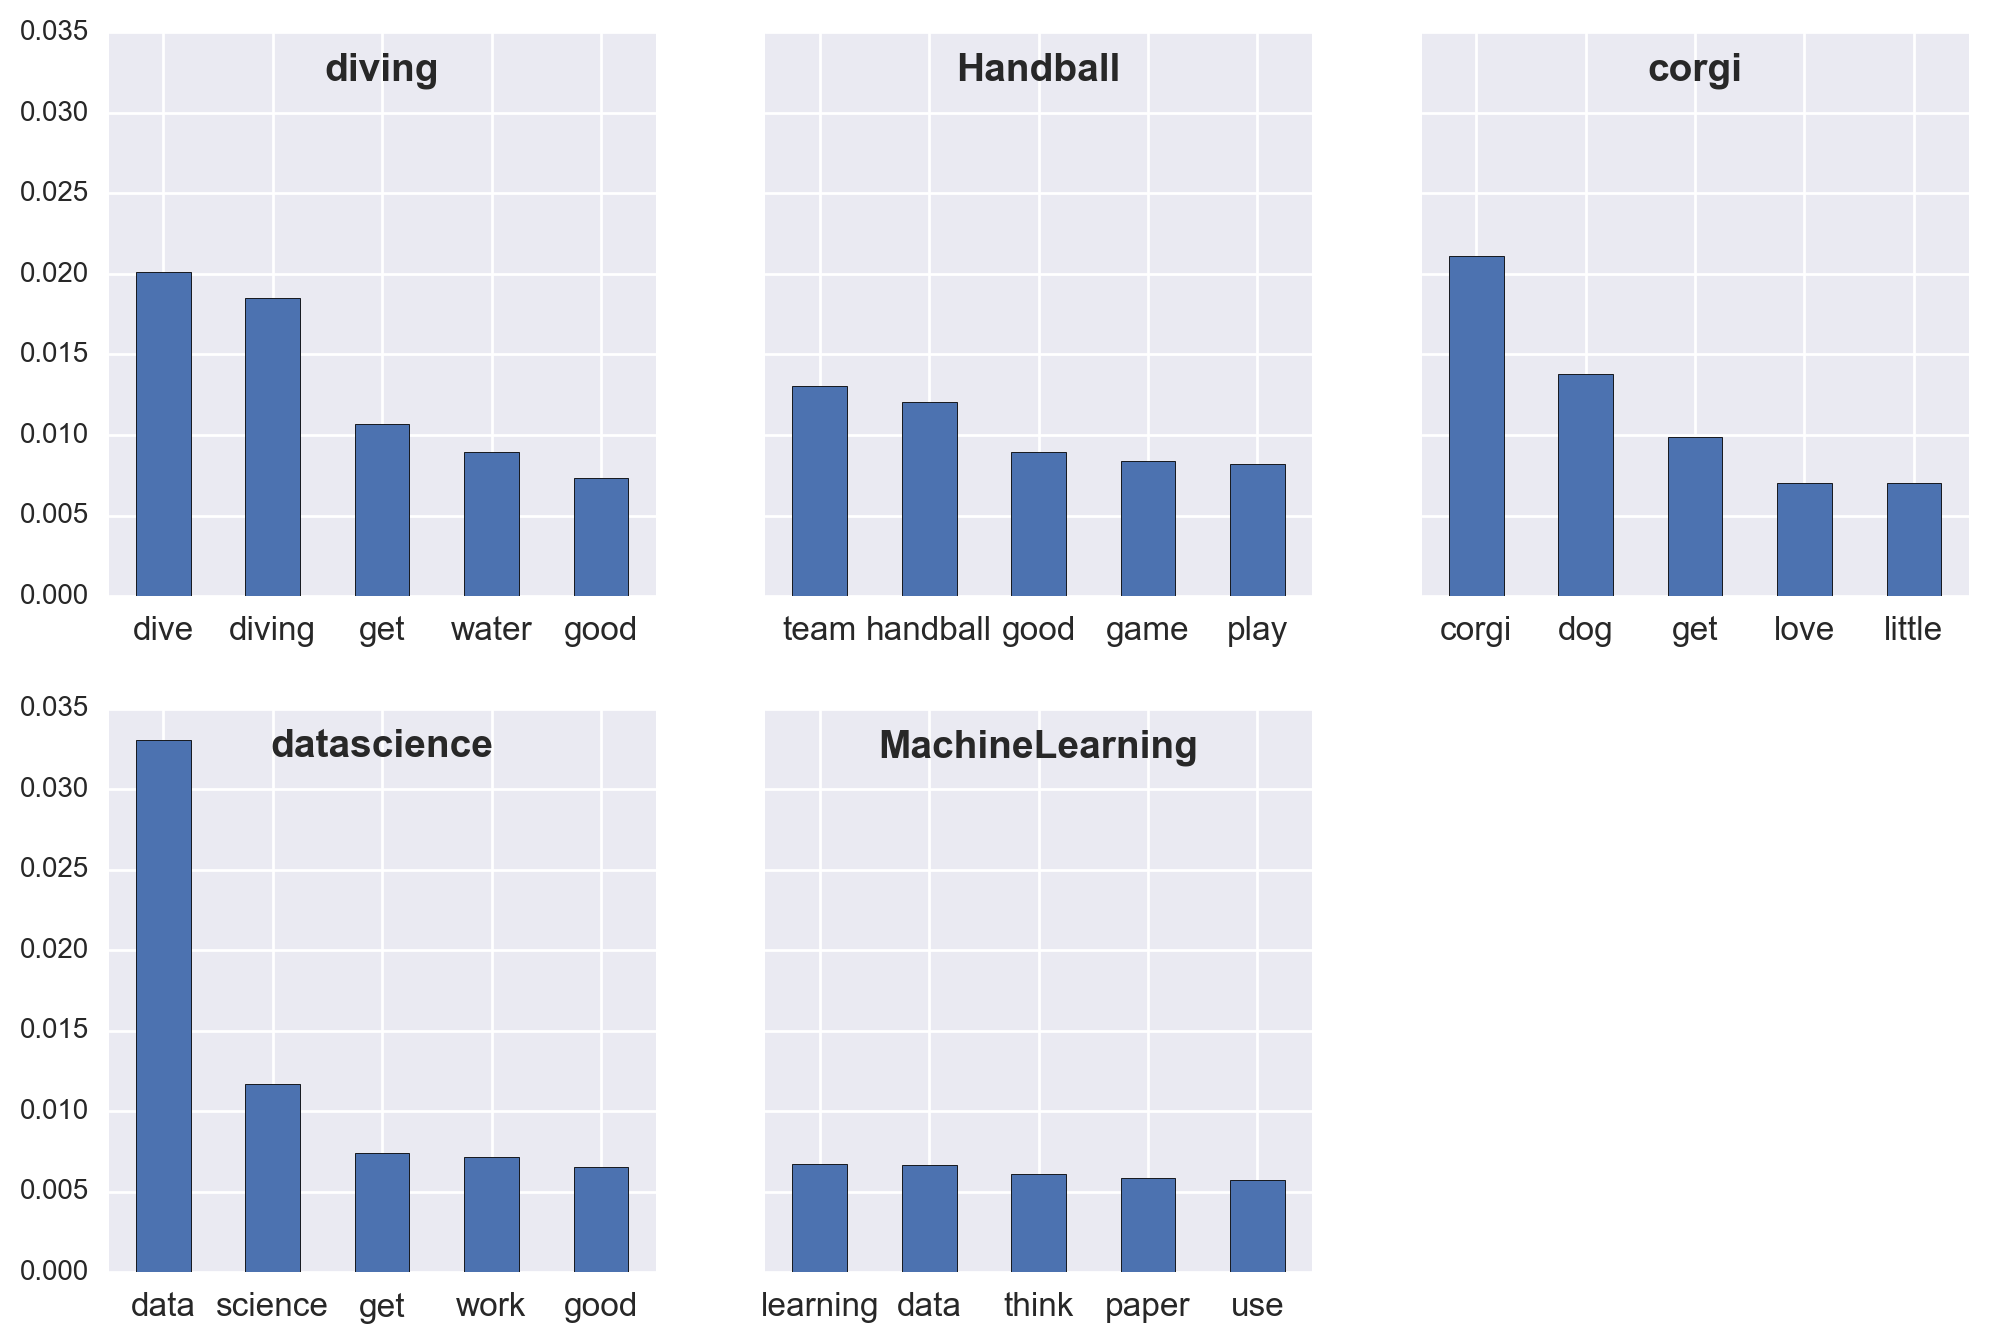

In [162]:
fig, axes = plt.subplots(2, 3, sharex = False, sharey = True, figsize = (12, 8))
cnt = 0
for i in range(2):
    for j in range(3):
        if cnt <= 4:
            rel_freq_list[cnt][:5].plot.bar(ax = axes[i, j])
            axes[i, j].set_xticklabels(rel_freq_list[cnt][:5].index.tolist(), rotation = 0, fontsize = 12)
            axes[i, j].set_xlabel("", fontsize = 12)
            axes[i, j].text(0.5, 0.915, all_subreddit_names[cnt], fontweight = "bold", fontsize = 14, 
                            horizontalalignment = 'center', transform = axes[i, j].transAxes)
            cnt = cnt + 1
        else: 
            axes[i, j].axis('off')

In [163]:
fig.savefig('frequencies.png', bbox_inches = 'tight', pad_inches = 0, dpi = 500, format = 'png')

---

# <a name="wmd">4. Apply modified WMD to validation sets</a>

The function that gives the modified WMD distance between the input and a channel's representative message (see my blog for more info):

In [142]:
def wmd_mod(s1, i_cat, no_top):
    s2 = " ".join(rel_freq_list[i_cat].index.tolist()[:no_top])
    vect_fit = vectorizer.fit([s1, s2])
    spacy_words = nlp(" ".join(vect_fit.get_feature_names()))  
    v_1, v_2 = vect_fit.transform([s1, s2])
    v_1 = v_1.toarray().ravel().astype(np.double)
    v_2 = v_2.toarray().ravel().astype(np.double)
    for i_s in range(len(v_2)):
        if str(spacy_words[i_s]) in rel_freq_list[i_cat][:no_top]:
            v_2[i_s] = rel_freq_list[i_cat][str(spacy_words[i_s])]
        else: 
            v_2[i_s] = 0
    v_1 /= v_1.sum()
    v_2 /= v_2.sum()    
    w2v_vectors = [w.vector for w in spacy_words]
    dist_matrix = euclidean_distances(w2v_vectors).astype(np.double)
    return emd(v_1, v_2, dist_matrix)

Define the full validation set:

In [164]:
valid_full = []
valid_true_labels = []
cnt = 0
for datum in data_valid:
    valid_full = valid_full + datum
    valid_true_labels = valid_true_labels + [all_subreddit_names[cnt]] * len(datum)
    cnt = cnt + 1
len(valid_full)

4916

Define the grid over which we'll search for the optimal number of top words:

In [165]:
top_words_list = range(10, 200, 10)
print top_words_list

[10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190]


Run the validation loop (could take a few hours due to the size of the validation set and the size of the parameter grid)

In [ ]:
t_start = time.time()
acc_list = []
for no_top in top_words_list:
    valid_predict_labels = []
    print "Working on n_top = " + str(no_top)
    for i_example in range(len(valid_full)):
        wmd_avgs = [wmd_mod(valid_full[i_example], i, no_top) for i in range(len(data_valid))]
        index_min = wmd_avgs.index(min(wmd_avgs))
        valid_predict_labels = valid_predict_labels + [all_subreddit_names[index_min]]
        output_string = "\rExample " + str(i_example + 1) + " / " + str(len(valid_full))
        sys.stdout.write(output_string)
        sys.stdout.flush()
    acc_list.append(accuracy_score(valid_true_labels, valid_predict_labels))
    print ""   
t_end = time.time()

Plot the validation set accuracy vs. number of top words considered:

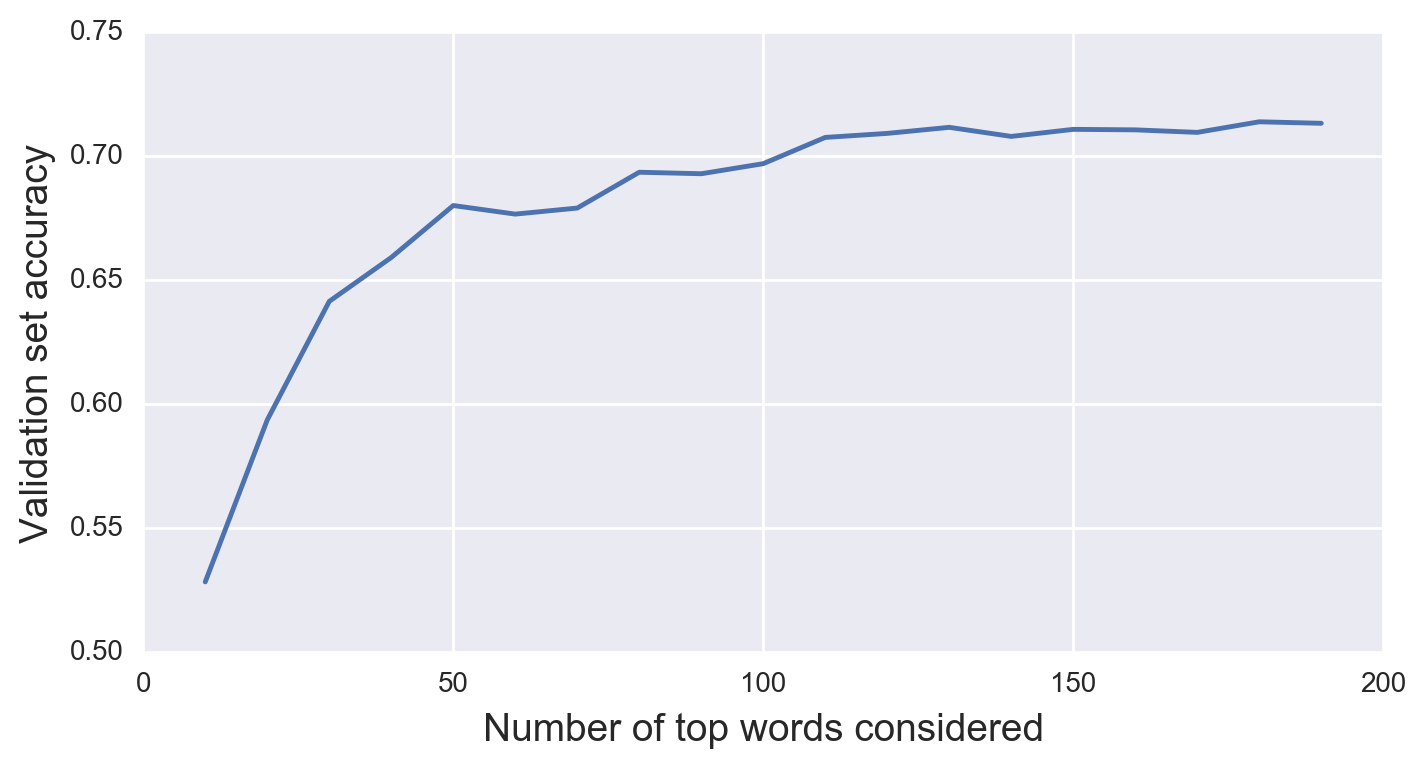

In [173]:
fig, ax = plt.subplots(figsize = (8, 4))
ax.plot(top_words_list, acc_list)
ax.set_xlabel("Number of top words considered", fontsize = 14)
ax.set_ylabel('Validation set accuracy', fontsize = 14);

Optimal number of top words

In [176]:
no_top_optimal = top_words_list[acc_list.index(max(acc_list))]
no_top_optimal

180

---

#  <a name="test">5. Accuracy on the test set</a>

Here we'll use the model with optimal number of top words on the test set:

In [177]:
test_full = []
test_true_labels = []
cnt = 0
for datum in data_test:
    test_full = test_full + datum
    test_true_labels = test_true_labels + [all_subreddit_names[cnt]] * len(datum)
    cnt = cnt + 1
len(test_full)

2500

Find the accuracy:

In [156]:
test_predict_labels = []
for i_example in range(len(test_full)):
    wmd_avgs = [wmd_mod(test_full[i_example], i, no_top_optimal) for i in range(len(data_test))]
    index_min = wmd_avgs.index(min(wmd_avgs))
    test_predict_labels = test_predict_labels + [all_subreddit_names[index_min]]
    output_string = "\rExample " + str(i_example + 1) + " / " + str(len(test_full))
    sys.stdout.write(output_string)
    sys.stdout.flush()
test_acc = accuracy_score(test_true_labels, test_predict_labels)
test_acc

Example 2500 / 2500

0.70879999999999999

Add the empty examples to get the effective accuracy:

In [258]:
test_eff_predict_labels = test_predict_labels

In [259]:
test_eff_predict_labels = test_predict_labels
for i_example in range(len(test_full)):
    if len(test_full[i_example]) == 0 and test_true_labels[i_example] != test_predict_labels[i_example]: 
        test_eff_predict_labels[i_example] = test_true_labels[i_example]

In [261]:
test_eff_acc = accuracy_score(test_true_labels, test_eff_predict_labels)
test_eff_acc

0.72799999999999998

Let's look at the confusion matrix:

In [262]:
conf_mat = confusion_matrix(test_true_labels, test_eff_predict_labels, labels = all_subreddit_names)
conf_mat = conf_mat / conf_mat.astype(np.float).sum(axis = 1)
conf_mat

array([[ 0.728,  0.008,  0.072,  0.072,  0.12 ],
       [ 0.09 ,  0.73 ,  0.078,  0.038,  0.064],
       [ 0.084,  0.012,  0.812,  0.022,  0.07 ],
       [ 0.046,  0.002,  0.02 ,  0.72 ,  0.212],
       [ 0.048,  0.018,  0.04 ,  0.244,  0.65 ]])

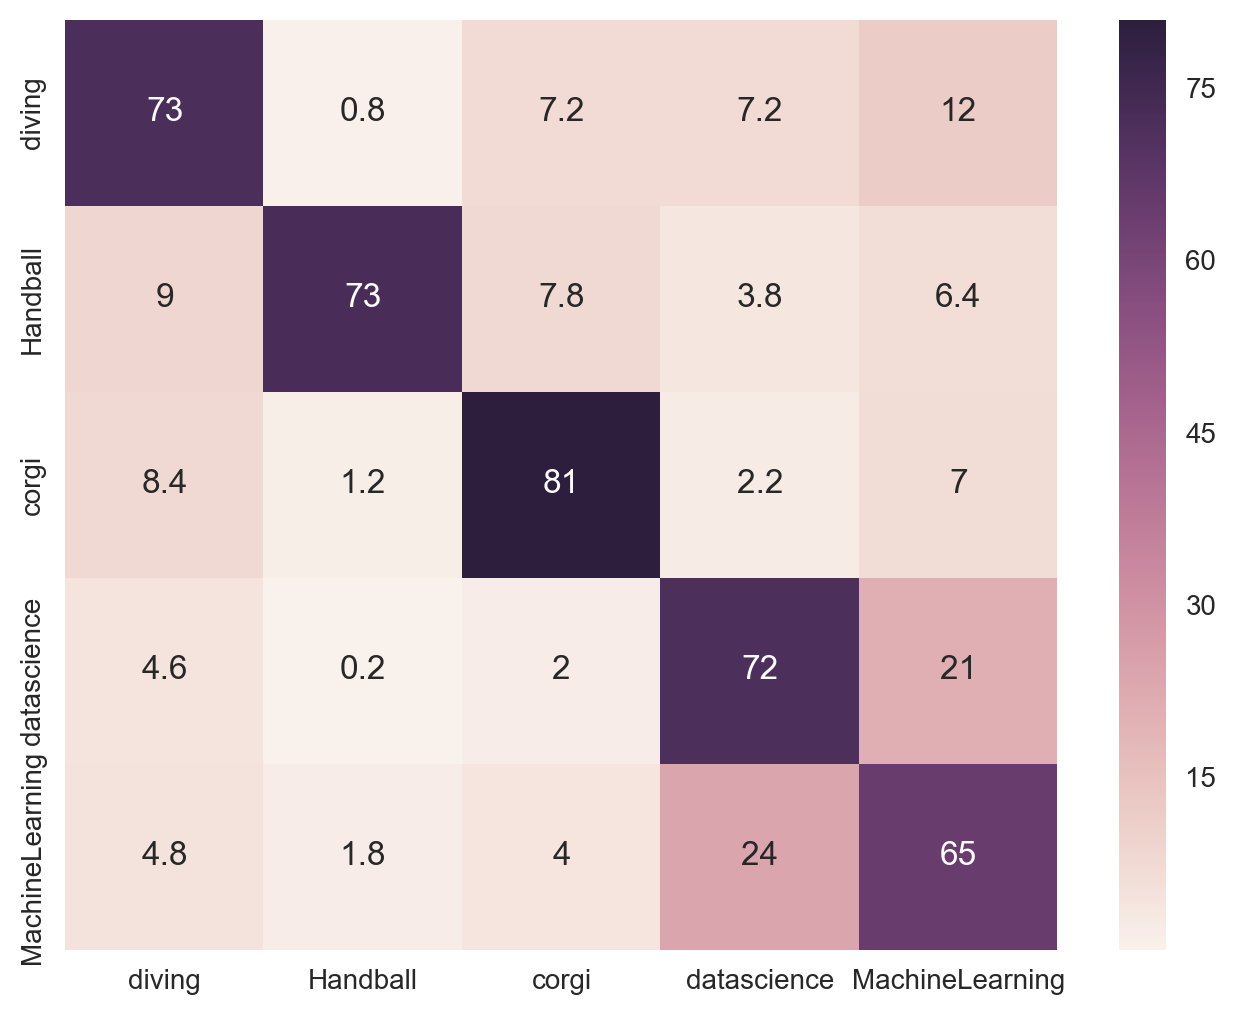

In [263]:
conf_df = pd.DataFrame(conf_mat * 100, index = all_subreddit_names, columns = all_subreddit_names)
fig, ax = plt.subplots(figsize = (8, 6))
seaborn.heatmap(conf_df, annot = True, ax = ax);

In [264]:
fig.savefig('confusion_matrix.png', bbox_inches = 'tight', pad_inches = 0, dpi = 500, format = 'png')

---

# <a name="thresh">6. Implementing a threshold</a>

Let's look at the examples we got wrong and their corresponding scores. First we extract all the scores and then look at the examples we got wrong in a dataframe:

In [185]:
optimal_scores = [[wmd_mod(example, i, no_top_optimal) 
                   for example in test_full] 
                  for i in range(len(data_test))]

In [187]:
outcome_df = pd.DataFrame({"post":test_full, "true":test_true_labels, "prediction":test_predict_labels,
                          all_subreddit_names[0]: optimal_scores[0], all_subreddit_names[1]: optimal_scores[1],
                          all_subreddit_names[2]: optimal_scores[2],all_subreddit_names[3]: optimal_scores[3],
                          all_subreddit_names[4]: optimal_scores[4]},
                          columns = ["post", "true",  "prediction", all_subreddit_names[0],all_subreddit_names[1],
                                    all_subreddit_names[2], all_subreddit_names[3], all_subreddit_names[4]])

In [191]:
outcome_df[outcome_df['true'] != outcome_df['prediction']].head(10)

,post,true,prediction,diving,Handball,corgi,datascience,MachineLearning
1,going use anything special,diving,MachineLearning,5.648222,5.960952,5.854763,5.559248,5.539884
2,love rex,diving,corgi,7.197300,7.309761,6.879345,7.355230,7.312234
3,nice love,diving,corgi,6.436094,6.700673,6.279668,6.717220,6.649892
6,nose blocking device regulator attaches padded...,diving,MachineLearning,7.618587,7.847395,7.682667,7.637739,7.544745
10,ahh saw picture phone thought enjoy new hat,diving,corgi,6.411407,6.501221,6.284406,6.495543,6.405297
11,sho nuff,diving,corgi,7.655625,7.716720,7.538473,7.864629,7.804031
18,scuba report problem reddit delete comment www...,diving,MachineLearning,7.188408,7.480170,7.409891,6.986196,6.871748
22,deleted,diving,MachineLearning,8.614324,8.636308,8.549680,8.371519,8.351423
24,add swallowing moving jaw successful ears coup...,diving,MachineLearning,6.195571,6.446468,6.295009,6.218523,6.109035
27,similar issue started problem eustachian tubes...,diving,MachineLearning,6.393441,6.673910,6.566191,6.502599,6.269727


As we can see, a lot of these comments are in fact generic, and could belong to any category. In fact, our model picked up on that: the scores are somewhat close together. Let's try to filter out some of these by introducing a threshold:

In [206]:
list2 = []
list3 = []
thresh_list = np.linspace(0.001,0.03,100)
for thresh in thresh_list:
    predicted_labels = []
    generic = []
    for i_test in range(len(test_full)):
        scores_local = [optimal_scores[i][i_test] for i in range(len(data_test))]
        index_min = scores_local.index(min(scores_local))
        top_indices = np.argsort(scores_local)
        top_score = scores_local[top_indices[0]]
        next_score = scores_local[top_indices[1]]
        rel_diff = np.abs(top_score - next_score) / top_score
        predicted_labels.append(all_subreddit_names[index_min])
        if rel_diff > thresh: generic.append(False)
        else: generic.append(True)
    count2 = 0
    count3 = 0
    for i in range(len(test_full)):
        if test_true_labels[i] == predicted_labels[i] and generic[i] == True: count2 = count2 + 1
        if test_true_labels[i] != predicted_labels[i] and generic[i] == False: count3 = count3 + 1
    list2.append(count2 / len(test_full))
    list3.append(count3 / len(test_full))

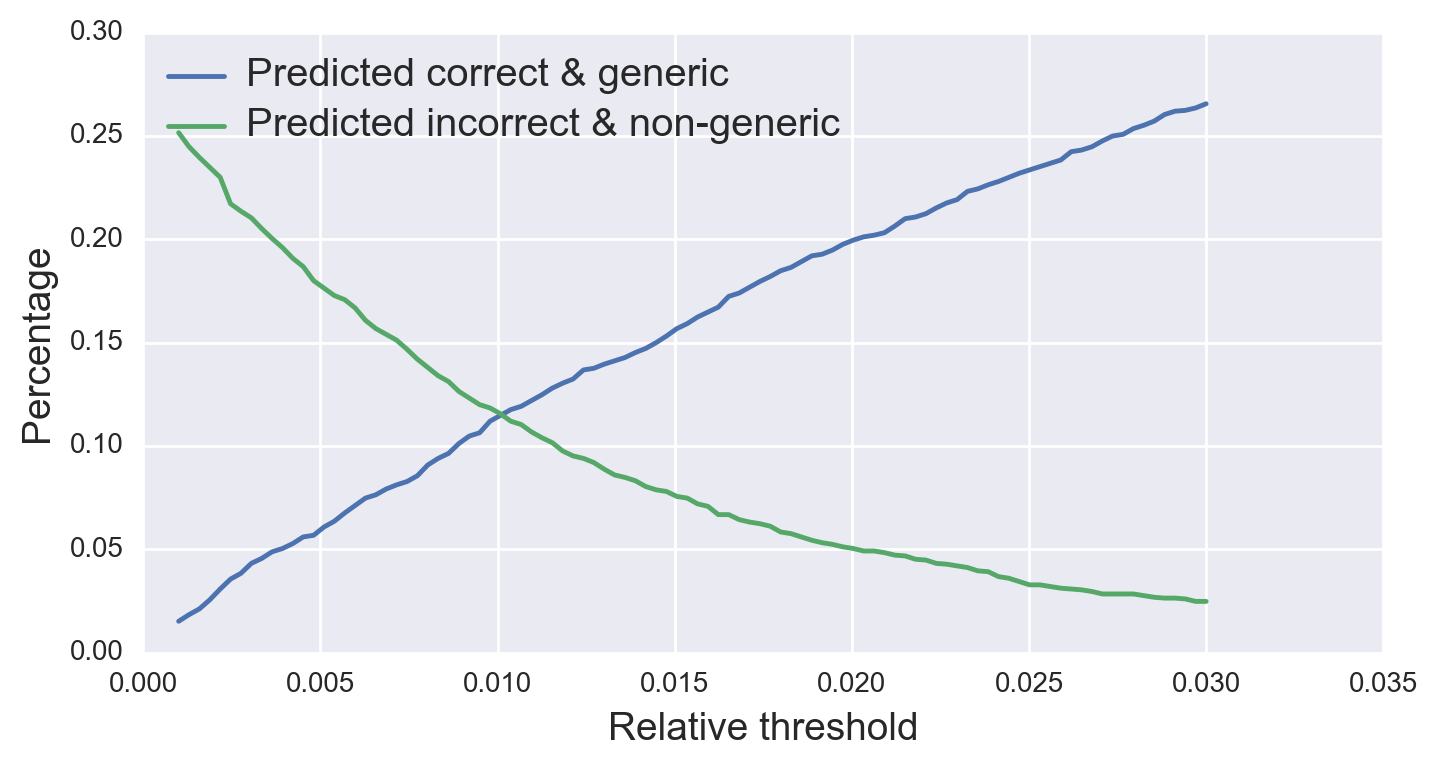

In [207]:
fig, ax = plt.subplots(figsize = (8, 4))
ax.plot(thresh_list, list2, label = "Predicted correct & generic")
ax.plot(thresh_list, list3, label = "Predicted incorrect & non-generic")
ax.set_xlabel("Relative threshold", fontsize = 14)
ax.set_ylabel('Percentage', fontsize = 14)
legend = ax.legend(loc='upper left');
for label in legend.get_texts():
    label.set_fontsize('large')

In [288]:
fig.savefig('threshold.png', bbox_inches = 'tight', pad_inches = 0, dpi = 500, format = 'png')

Let's find the intersection of the two curves and use that as our optimal threshold:

In [226]:
arg_cross = np.argwhere(np.diff(np.sign(np.array(list2) - np.array(list3))) != 0)[0, 0]

In [227]:
thresh_opt = (thresh_list[arg_cross] + thresh_list[arg_cross + 1]) / 2
thresh_opt

0.010227272727272725

For this value of the threshold, let's flag the generic posts:

In [228]:
predicted_labels = []
generic = []
for i_test in range(len(test_full)):
    scores_local = [optimal_scores[i][i_test] for i in range(len(data_test))]
    index_min = scores_local.index(min(scores_local))
    top_indices = np.argsort(scores_local)
    top_score = scores_local[top_indices[0]]
    next_score = scores_local[top_indices[1]]
    rel_diff = np.abs(top_score - next_score) / top_score
    predicted_labels.append(all_subreddit_names[index_min])
    if rel_diff > thresh_opt: generic.append(False)
    else: generic.append(True)

Now we need to manually inspect all the posts that have been flagged as generic and we have incorrectly classified: the truly generic posts will then contribute to our overall accuracy:

In [232]:
generic_posts = []
for i_test in range(len(test_full)):
    if generic[i_test] == True and predicted_labels[i_test] != test_true_labels[i_test]:
        generic_posts.append(test_full[i_test])

In [267]:
generic_posts_clean = [g for g in generic_posts if len(g) > 0]
len(generic_posts_clean)

393

After manually inspecting the above, I found that 286 are indeed generic:

In [272]:
incorrect_generics = 286

In [273]:
(test_eff_acc * len(test_full) + incorrect_generics) / len(test_full)

0.84240000000000004